In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [Synaptic theory of working memory, Mongillo et al. 2008](http://science.sciencemag.org/content/319/5869/1543),
a two parameter model for vesicle release and recovery is detailed.  
These two parameters are:  
$x$ : The fraction of vesicles available for release (from the maximum RRP)  
$u$ : The fraction of vesicles in $x$ that are released in response to a spike - This models the presynaptic intracellular states affecting release probabilites  


The behaviour of each of these is governed by the following differential equations:
$$
{dx\over dt} = {{1-x} \over \tau_D} - u x \delta(t-t_{sp})\\
{du\over dt} = {{U-u}\over \tau_f} + U(1-u)(\delta(t-t_{st})
$$
where $U$ is some baseline value of $u$ towards which it grows or decays.
$tau_D$ and $tau_f$ are decay constants for $x$ and $u$ respectively, with $tau_f >> tau_D$

To determine a mean uniform recovery rate for vesicles based on their data,  
We are interested only in what happens to $x$.  
We use their equation for $x$ to determine how long it will take the pool to replenish to 99% of its contents,  
and then divide our maximal pool size (20) by that time to arrive at the time it should take for a single vesicle  
to recover according to their model

In [39]:
from scipy.integrate import odeint
# Modeling only the increasing part of dx / dt
def simple_growth(val, time, tau):
    return (1 - val) / tau

number_of_vesicles = 20
times = np.linspace(0, 2, 201)  # Looking at a 2 second time range
initial_value = 0
tau_D = 0.2  # Value obtained from the article and supplements

# solving for x
x_t = odeint(simple_growth, initial_value, times, (tau_D, ))

# finding first time instant when recovery is complete (99%)
recovery_99_ms = times[np.isclose(x_t[:, 0], 0.99, atol=1e-4)][0] * 1000

print(f'Reached 99% recovery at t={recovery_99_ms}ms')
single_vesicle_recovery_time = recovery_99_ms / number_of_vesicles
print(f'With {number_of_vesicles} vesicles, this translates to one every {single_vesicle_recovery_time} seconds')

Reached 99% recovery at t=920.0ms
With 20 vesicles, this translates to one every 46.0 seconds


Now we turn to implementing a replenishment model of our own,  
for our model, we will replace $x$ with $n$ denoting the number of vesicles such that:
$$
{dn\over dt} = {{1\over \tau_n} \times (1-\delta(n_{(t)}-n_{max}))} - n_{released}
$$
where $tau_n = 46$ and $n_{max}$ denotes the full pool capacity,  


*note that this expression results in continuous values of n,  
for downstream purposes (such as vesicle release limites) this will be discretized*

Lets generate some test data and test the behaviour of this function

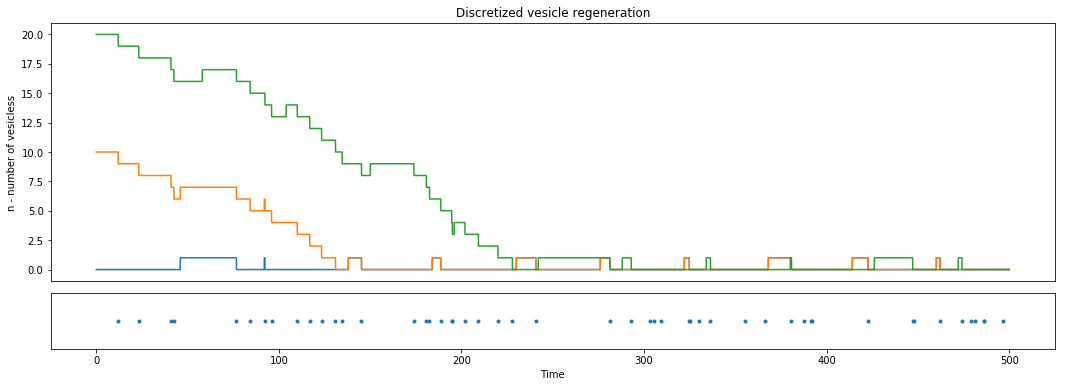

In [130]:
stimulus_duration = 500  # ms
dt_ms = 0.01

num_released = 50
max_pool_size = 20
tau_n = 46
starting_pool_size = [0, 10, 20]

random_seed = 15
np.random.seed(random_seed)

times = np.arange(0 + dt_ms, stimulus_duration + dt_ms, dt_ms)
random_release_times = np.sort(np.random.choice(times, size=num_released, replace=False))

n = {pool_size: np.zeros_like(times) for pool_size in starting_pool_size}
fig = plt.figure(figsize=(18, 6))
grid_shape = (5, 1)
ax_n = plt.subplot2grid(shape=grid_shape, loc=(0, 0), rowspan=4, fig=fig)
for key in n:
    n[key][0] = key
    for i, t in enumerate(times[:-1]):
        replenished = (1 / tau_n) * dt_ms * (1 - np.isclose(n[key][i], max_pool_size))
        released = int(t in random_release_times) if int(n[key][i]) > 0 else 0
        dn = replenished - released
        n[key][i+1] = n[key][i] + dn
    ax_n.plot(times, n[key].round(5).astype(int), label=key)
ax_n.set_title('Discretized vesicle regeneration')
ax_n.set_ylabel('n - number of vesicless')
ax_n.set_xticks([])
ax_r = plt.subplot2grid(shape=grid_shape, loc=(4, 0), rowspan=1, fig=fig)
ax_r.scatter(random_release_times, [0] * num_released, marker='.')
ax_r.set_xlim(ax_n.get_xlim())
ax_r.set_yticks([])
ax_r.set_xlabel('Time');

In [81]:
n

{0: array([ 0.        ,  0.02173913,  0.04347826, ..., 20.        ,
        20.        , 20.        ]),
 10: array([10.        , 10.02173913, 10.04347826, ..., 20.        ,
        20.        , 20.        ]),
 20: array([20., 20., 20., ..., 20., 20., 20.])}

In [79]:
released

0